In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import copy
import socket
import os
import sys
import pandas as pd
import scipy.io as sio
import matplotlib
import scipy.signal as sg
from scipy.io import wavfile
import math
import scipy as sp
import pylab
import h5py
import pickle
import seaborn as sns
import random
import collections
import logging
import datetime
import itertools
import tensorflow as tf
import tensorflow.keras as keras
import sklearn
import gc
import importlib
import librosa
import librosa.display
from glob import glob
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [2]:
from math_utils import *

## set parameters

In [3]:
spec_pars = {'fft_size': 2048, 
             'step_size': 256,
             'n_stars':int(hz2star(44100/2)),
             'fmin': 20}

In [4]:
all_analyses = ['stable_length']

In [5]:
debug = False

In [6]:
256/44100

0.005804988662131519

# Star scale

In [7]:
species = 'Starling'

In [8]:
dataset = Dataset(species)

In [9]:
subjs = dataset.subjs

In [10]:
species_save_folder = dataset.path_save

### test first

hz

(1025, 758)


[Text(0.5, 1.0, '/mnt/cube/kai/data_processed/datasets/Starling/stable_length/B335/2008-06-04_11-37-00-000000-395687.wav')]

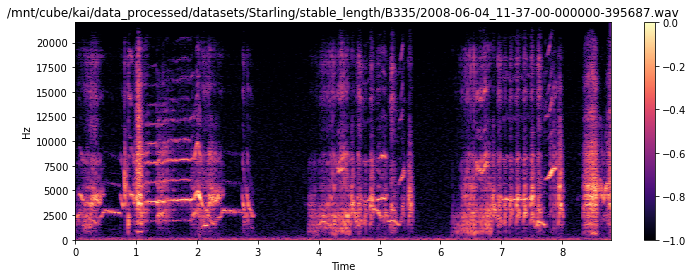

In [11]:
subj = subjs[0]
analysis = all_analyses[0]
analysis_folder = os.path.join(species_save_folder, analysis)
subj_wavs = glob(os.path.join(analysis_folder, subj, '*.wav'))
wav = subj_wavs[0]

y, sr = librosa.load(wav, sr=None)
S_full = np.abs(librosa.stft(y, n_fft=spec_pars['fft_size'], hop_length=spec_pars['step_size'], 
                             win_length=spec_pars['fft_size'], window='hann')) ** 2
S_norm = librosa.util.normalize(librosa.power_to_db(S_full, ref=np.max))
    
print(S_norm.shape)
fig, ax = plt.subplots(figsize=(12, 4))
img = librosa.display.specshow(S_norm, x_axis='time', y_axis = 'hz',
                         sr=sr, ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title=wav)

mel

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


[Text(0.5, 1.0, '/mnt/cube/kai/data_processed/datasets/Starling/stable_length/B335/2008-06-04_11-37-00-000000-395687.wav')]

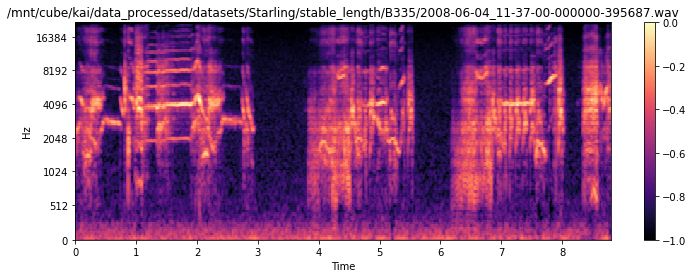

In [12]:
S_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=spec_pars['fft_size'], fmax=sr/2, hop_length=spec_pars['step_size'], 
                             win_length=spec_pars['fft_size'], window='hann')
S_mel = librosa.util.normalize(librosa.power_to_db(S_mel, ref=np.max))

fig, ax = plt.subplots(figsize=(12, 4))
img = librosa.display.specshow(S_mel, x_axis='time', y_axis = 'mel',
                         sr=sr, ax=ax, fmax=sr/2)
fig.colorbar(img, ax=ax)
ax.set(title=wav)

star

[Text(0.5, 1.0, '/mnt/cube/kai/data_processed/datasets/Starling/stable_length/B335/2008-06-04_11-37-00-000000-395687.wav')]

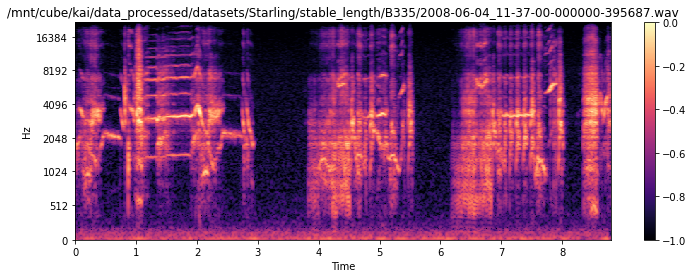

In [13]:
S_star = star_spectrogram(y=y, sr=sr, n_stars=spec_pars['n_stars'], n_fft=spec_pars['fft_size'], fmax=sr/2, hop_length=spec_pars['step_size'], 
                             win_length=spec_pars['fft_size'], window='hann')
S_star = librosa.util.normalize(librosa.power_to_db(S_star, ref=np.max))

fig, ax = plt.subplots(figsize=(12, 4))
img = librosa.display.specshow(S_star, x_axis='time', y_axis = 'mel',
                         sr=sr, ax=ax, fmax=sr/2)
fig.colorbar(img, ax=ax)
ax.set(title=wav)

In [14]:
S_star.shape

(291, 758)

In [15]:
for analysis in all_analyses:
    analysis_folder = os.path.join(species_save_folder, analysis)
    log_folder = extend_folder(analysis_folder, 'log')
    spec_file = os.path.join(log_folder, 'all_specs_star.p')
    if os.path.exists(spec_file):
        paragraph_print(f'Skipping {species} {analysis}', separation = '>')
        continue
    print(f'Starting {analysis}')
    all_specs = list()
    all_subjs = list()
    all_wavs = list()
    min_spec_len = 9999
    for subj in subjs:
        subj_wavs = glob(os.path.join(analysis_folder, subj, '*.wav'))
        if not len(subj_wavs):
            continue
        for wav in subj_wavs:
            y, sr = librosa.load(wav, sr=None)
            S_star = star_spectrogram(y=y, sr=sr, n_stars=spec_pars['n_stars'], n_fft=spec_pars['fft_size'], 
                                      hop_length=spec_pars['step_size'], win_length=spec_pars['fft_size'], 
                                      window='hann')
            S_norm = librosa.util.normalize(librosa.power_to_db(S_star, ref=np.max))
            if S_norm.shape[1]<min_spec_len:
                min_spec_len = S_norm.shape[1]
                print(f'Min len for {analysis} updated to: {min_spec_len}')
            if debug:
                print(S_norm.shape)
                fig, ax = plt.subplots(figsize=(12, 4))
                img = librosa.display.specshow(S_norm, x_axis='time', y_axis = 'mel',
                                         sr=sr, ax=ax)
                fig.colorbar(img, ax=ax)
                ax.set(title=wav)
                break
            all_specs.append(S_norm)
            all_subjs.append(subj)
            all_wavs.append(wav)
        if debug:
            break
    if debug:
        break
    all_specs_short = [spec[:,:min_spec_len] for spec in all_specs]
    analysis_df = pd.DataFrame()
    analysis_df['name'] = all_subjs
    analysis_df['wav'] = all_wavs
    analysis_df['spec'] = all_specs_short
    analysis_df.to_pickle(spec_file)
    del analysis_df
    paragraph_print(f'All done with {species} {analysis}', separation = '-')

Skipping Starling stable_length
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


In [ ]:
analysis_df = pickle.load(open(spec_file, 'rb'))

[Text(0.5, 1.0, '/mnt/cube/kai/data_processed/datasets/Starling/stable_length/b1160/2017-11-14_07-48-17-100000-2023859.wav')]

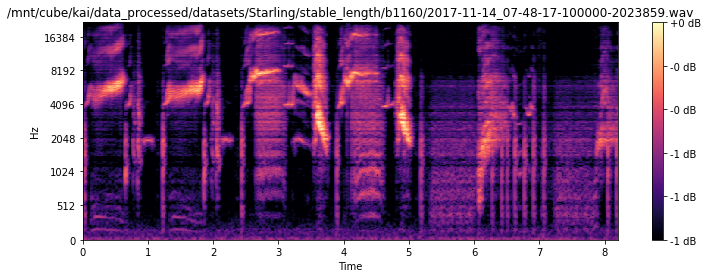

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))
img = librosa.display.specshow(analysis_df.spec.values[-1], x_axis='time',
                         y_axis='mel', sr=sr, ax=ax, fmax=22050)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title=analysis_df.wav.values[-1])